In [1]:
import seml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax.tree_util as jtu

collection = 'sparse_zhai_hf_newton'

In [38]:
result = seml.get_results(collection, to_data_frame=True, progress=False)
result

,_id,config.overwrite,config.db_collection,config.basis,config.name,config.pp,config.restricted,config.x2c,config.seed,result.energy,result.converged
0,1,1,sparse_zhai_hf_newton,sto-6g,zhai_et_al_2023_HC_df2-svp,"[C, S, Fe]",False,False,552544397,-323.122281,True
1,2,2,sparse_zhai_hf_newton,def2-svp,zhai_et_al_2023_HC_df2-svp,"[C, S, Fe]",False,False,358896711,-327.417713,True
2,5,5,sparse_zhai_hf_newton,sto-6g,zhai_et_al_2023_HS_df2-svp,"[C, S, Fe]",False,False,241043737,-323.237712,True
3,6,6,sparse_zhai_hf_newton,def2-svp,zhai_et_al_2023_HS_df2-svp,"[C, S, Fe]",False,False,690543969,-327.335752,True
4,9,9,sparse_zhai_hf_newton,sto-6g,zhai_et_al_2023_HFe_df2-svp,"[C, S, Fe]",False,False,736747623,-323.396199,True
...,...,...,...,...,...,...,...,...,...,...,...
78,92,92,sparse_zhai_hf_newton,ccpvdzdk,zhai_et_al_2023_HFe2_df2-svp,[],True,False,489107569,-4700.437033,True
79,93,93,sparse_zhai_hf_newton,sto-6g,zhai_et_al_2023_HFe2_df2-svp,[],True,True,489571039,-4711.889432,True
80,94,94,sparse_zhai_hf_newton,def2-svp,zhai_et_al_2023_HFe2_df2-svp,[],True,True,47756914,-4728.497011,True
81,95,95,sparse_zhai_hf_newton,ccpvdz,zhai_et_al_2023_HFe2_df2-svp,[],True,True,203172032,-4729.681067,True


In [39]:
result['result.converged'].all()

True

In [40]:
filters = [
    {
        'config.pp': ['C', 'S', 'Fe'],
        'config.basis': basis,
        'config.restricted': restricted,
    }
    for restricted in [True, False]
    for basis in ['sto-6g', 'def2-svp', 'ccecpccpvdz', 'ccecpccpvtz']
] + [
    {
        'config.pp': [],
        'config.x2c': x2c,
        'config.basis': basis,
        'config.restricted': restricted,
    }
    for restricted in [True, False]
    for x2c in [False, True]
    for basis in ['sto-6g', 'def2-svp', 'ccpvdz', 'ccpvdzdk']
]

In [41]:
def get_df(filter):
    return seml.get_results(collection, filter_dict=filter, to_data_frame=True, progress=False)

dfs = list(map(get_df, filters))

In [42]:
def get_energy_diffs(df):
    if len(df) == 0:
        return None
    HC_filter = df['config.name'].str.contains('HC_df2')
    if HC_filter.sum() == 0:
        return None
    HC = df[HC_filter].loc[0]
    others = df[~HC_filter]
    others.index = others['config.name']
    return others['result.energy'] - HC['result.energy']

energy_diffs = list(map(get_energy_diffs, dfs))

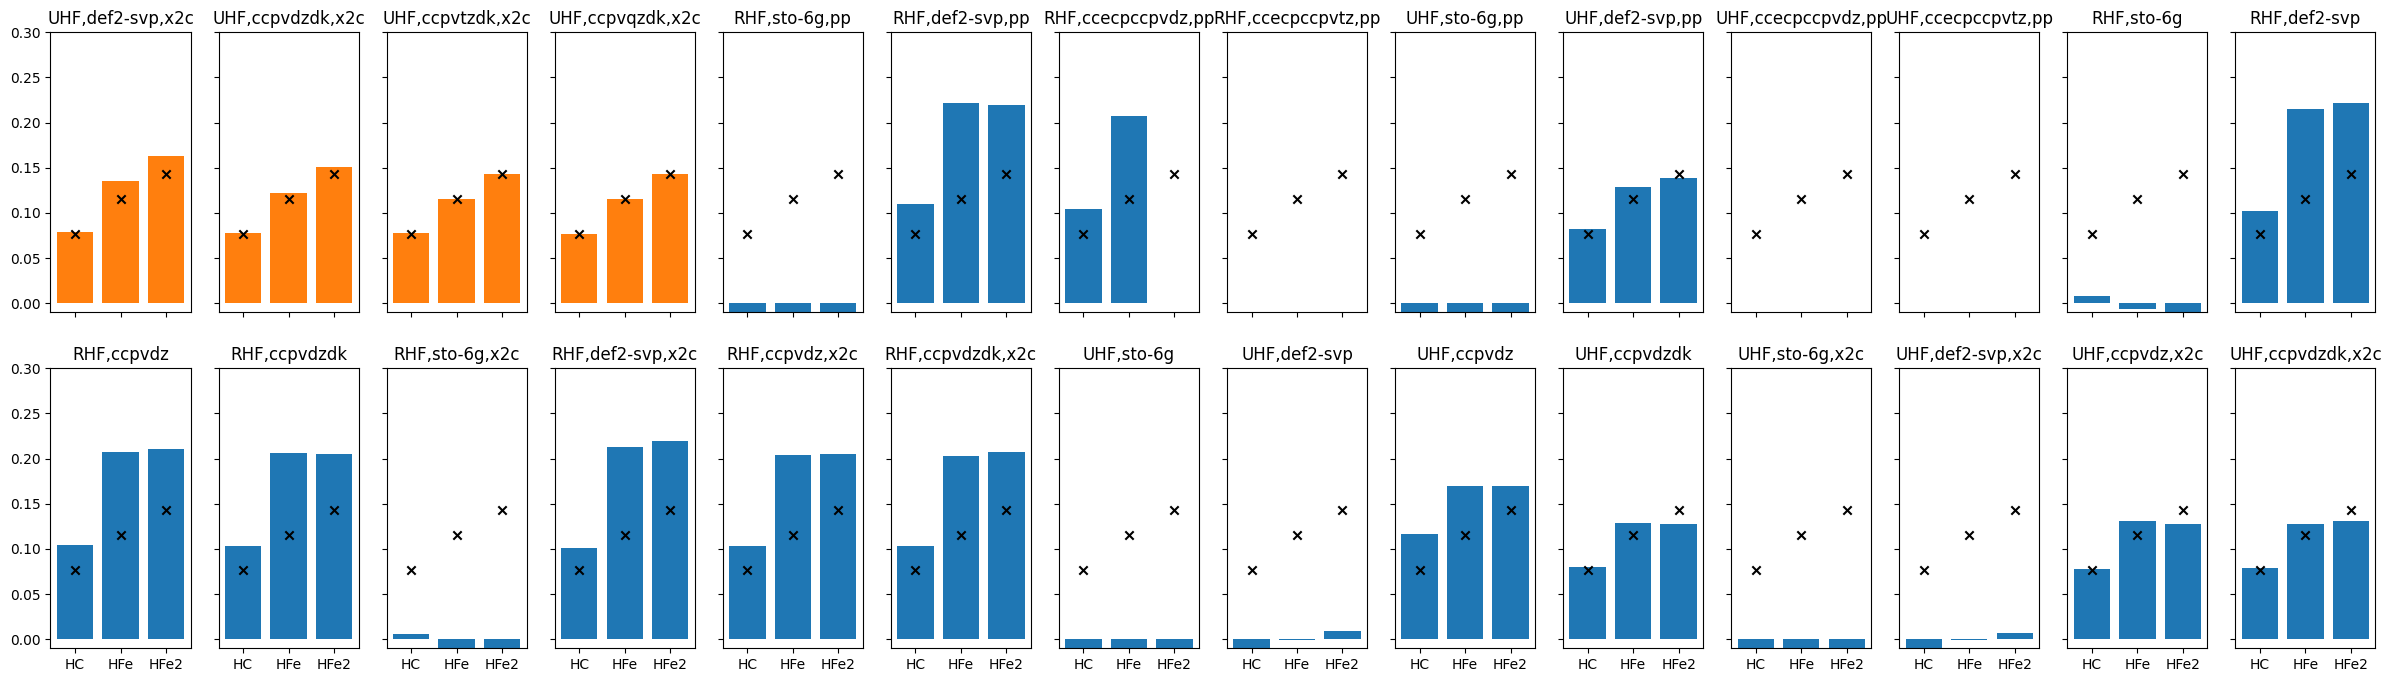

In [43]:
ref_data = np.array([
    [-248.7, -40.7, 108.3, 181.1],
    [-230.7, -26.9, 91.9, 165.7],
    [-221.5, -17.9, 83.2, 156.1],
    [-220.9, -17.9, 83.2, 155.6]
])
ref_data = ref_data * 0.00038
ref_data = ref_data[:, 1:] - ref_data[:, 0][:, None]
ref_methods = [f'UHF,{b},x2c' for b in ['def2-svp', 'ccpvdzdk', 'ccpvtzdk', 'ccpvqzdk']]
fig, axes = plt.subplots(2, (len(filters) + 1 + len(ref_methods)) // 2, figsize=(len(filters)*2.5 / 2, 8), sharey=True, sharex=True)
axes = axes.ravel()
for ax, ref, title in zip(axes, ref_data, ref_methods):
    ax.set_title(title)
    ax.bar(np.arange(3), ref, color='tab:orange')
    ax.scatter(np.arange(3), ref_data[-1], marker='x', color='black')
for cfg, energies, ax in zip(filters, energy_diffs, axes[len(ref_methods):]):
    # print(cfg)
    hf = 'RHF' if cfg['config.restricted'] else 'UHF'
    if cfg['config.pp']:
        title = f'{hf},{cfg["config.basis"]},pp'
    else:
        title = f'{hf},{cfg["config.basis"]}'
        if cfg['config.x2c']:
            title += ',x2c'
    ax.set_title(title)
    if energies is not None:
        ax.bar(np.arange(len(energies)), energies)
    ax.scatter(np.arange(3), ref_data[-1], marker='x', color='black')
axes[0].set_ylim(-0.01, 0.3)
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['HC', 'HFe', 'HFe2'])
plt.show()

In [13]:
import pyscf
from seml import Experiment
from sparse_wf.system import database


In [33]:
mol = database(name='zhai_et_al_2023_HC_df2-svp')
mol = pyscf.gto.M(atom="H 0 0 0; N 0 0 1.5", basis='def2-svp', charge=0, spin=0)
mol.basis = 'sto-3g'
mol.build()

In [37]:
mf = mol.UHF()
mf.verbose = 4
mf.max_cycle = 20
mf.chkfile = 'test.h5'
mf.init_guess = 'chk'
mf.kernel()
mf.newton().kernel()



******** <class 'pyscf.scf.uhf.UHF'> ********
method = UHF
initial guess = chk
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 20
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = test.h5
max_memory 4000 MB (current use 430 MB)
number electrons alpha = 4  beta = 4
Set gradient conv threshold to 3.16228e-05
init E= -54.0527872071183
  alpha nocc = 4  HOMO = -0.345493259326703  LUMO = 0.211718685289807
  beta  nocc = 4  HOMO = -0.345493258755966  LUMO = 0.211718685860543
cycle= 1 E= -54.0527872071183  delta_E= -1.42e-14  |g|= 1.04e-09  |ddm|= 3.01e-09
  alpha nocc = 4  HOMO = -0.345493259295742  LUMO = 0.211718685320768
  beta  nocc = 4  HOMO = -0.345493258657595  LUMO = 0.211718685958914
Extra cycle  E= -54.0527872071183  delta_E= 1.42e-14  |g|= 1.07e-09  |ddm|= 2.23e-09
converged SCF energy = -54.0527872071183  <S^2> = 1.

-54.05278720711829

In [24]:
mf = mol.UHF()
mf.verbose = 4
mf.max_cycle = 20
mf.newton().kernel()





******** <class 'pyscf.soscf.newton_ah.SecondOrderUHF'> ********
method = SecondOrderUHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 20
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpl5fhen0h
max_memory 4000 MB (current use 403 MB)
number electrons alpha = 90  beta = 90
******** <class 'pyscf.scf.uhf.UHF'> Newton solver flags ********
SCF tol = 1e-09
conv_tol_grad = None
max. SCF cycles = 20
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpl5fhen0h
max_cycle_inner = 12
max_stepsize = 0.05
ah_start_tol = 1e+09
ah_level_shift = 0
ah_conv_tol = 1e-12
ah_lindep = 1e-14
ah_start_cycle = 1
ah_max_cycle = 40
ah_grad_trust_region = 2.5
kf_interval = 4
kf_trust_region = 5
canonicalization = True
max_memory 4000 MB (current use 403 MB)
Set conv_tol_grad to 3.16228e

-4658.628762570745